In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours

In [2]:
data = pd.read_csv('amazon.csv')
# Check for duplicate, none found, no actions needed!
print(data.duplicated().sum())

#removing unnecessary columns
cleanData1 = pd.DataFrame(data[['rating','discounted_price','actual_price', 'discount_percentage', 'rating_count']])
# Drop rows with NaN values in the target variable (rating)
cleanData1.dropna(subset=['rating'], inplace=True)
cleanData1.dtypes

0


rating                 object
discounted_price       object
actual_price           object
discount_percentage    object
rating_count           object
dtype: object

In [3]:
#changing data to datatype float
cleanData1['discounted_price'] = cleanData1['discounted_price'].str.replace('₹', '').str.replace(',', '').astype(float)
cleanData1['actual_price'] = cleanData1['actual_price'].str.replace('₹', '').str.replace(',', '').astype(float)
cleanData1['discounted_amount'] = cleanData1['actual_price'] - cleanData1['discounted_price']
cleanData1['discount_percentage'] = cleanData1['discount_percentage'].str.replace('%', '').astype(float)
non_numeric_mask = ~cleanData1['rating'].str.match(r'^-?\d*\.?\d+$')
cleanData1.loc[non_numeric_mask, 'rating'] = np.nan
cleanData1['rating'] = cleanData1['rating'].astype(float)
cleanData1['rating_count'] = cleanData1['rating_count'].str.replace(',', '').astype(float)
cleanData1.dtypes

rating                 float64
discounted_price       float64
actual_price           float64
discount_percentage    float64
rating_count           float64
discounted_amount      float64
dtype: object

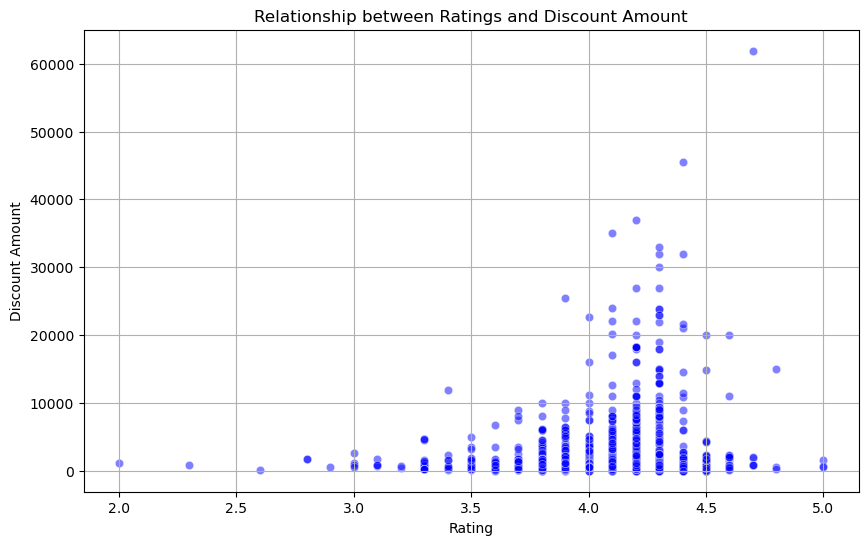

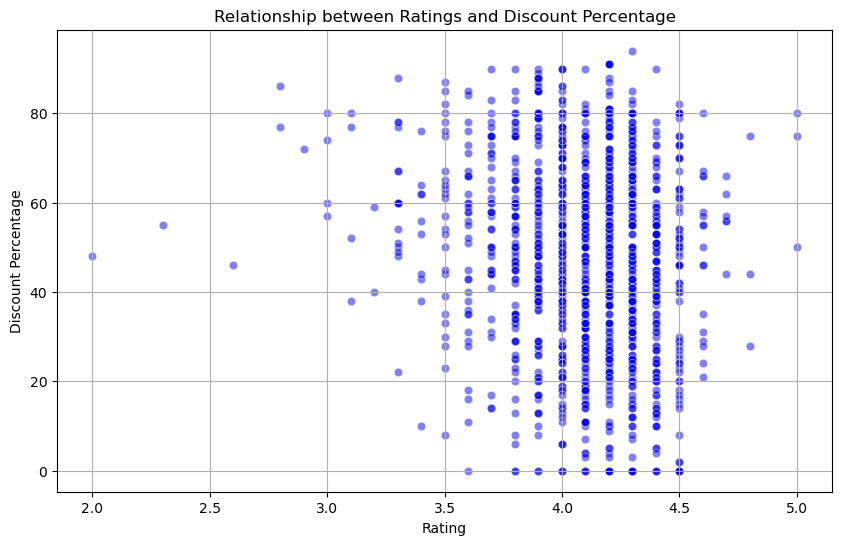

In [4]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=cleanData1, x='rating', y='discounted_amount', color='blue', alpha=0.5)
plt.title('Relationship between Ratings and Discount Amount')
plt.xlabel('Rating')
plt.ylabel('Discount Amount')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=cleanData1, x='rating', y='discount_percentage', color='blue', alpha=0.5)
plt.title('Relationship between Ratings and Discount Percentage')
plt.xlabel('Rating')
plt.ylabel('Discount Percentage')
plt.grid(True)
plt.show()

In [5]:
#remove outliers
Q1 = cleanData1.quantile(0.25)
Q3 = cleanData1.quantile(0.75)
interquartile_range = Q3-Q1
outliers = ((cleanData1 < (Q1 - 1.5 * (interquartile_range))) | (cleanData1 > (Q3 + 1.5 * (interquartile_range))))
cleanData1_filtered = cleanData1[~outliers.any(axis=1)]
cleanData1_filtered

,rating,discounted_price,actual_price,discount_percentage,rating_count,discounted_amount
0,4.2,399.00,1099.0,64.0,24269.0,700.00
2,3.9,199.00,1899.0,90.0,7928.0,1700.00
4,4.2,154.00,399.0,61.0,16905.0,245.00
5,3.9,149.00,1000.0,85.0,24871.0,851.00
6,4.1,176.63,499.0,65.0,15188.0,322.37
...,...,...,...,...,...,...
1460,4.0,379.00,919.0,59.0,1090.0,540.00
1461,4.1,2280.00,3045.0,25.0,4118.0,765.00
1462,3.6,2219.00,3080.0,28.0,468.0,861.00
1463,4.0,1399.00,1890.0,26.0,8031.0,491.00


In [6]:
# Creating the column "rating_weighted"
cleanData1_filtered.loc[:, 'rating_weighted'] = cleanData1_filtered['rating'] * cleanData1_filtered['rating_count']
cleanData1.loc[:, 'rating_weighted'] = cleanData1['rating'] * cleanData1['rating_count']

/var/folders/42/5tyh_zlx6vl10g79j9n6kynr0000gn/T/ipykernel_48603/3920970164.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleanData1_filtered.loc[:, 'rating_weighted'] = cleanData1_filtered['rating'] * cleanData1_filtered['rating_count']


In [7]:
# pip install imbalanced-learn
#pip install --upgrade scikit-learn
#pip install --upgrade imbalanced-learn

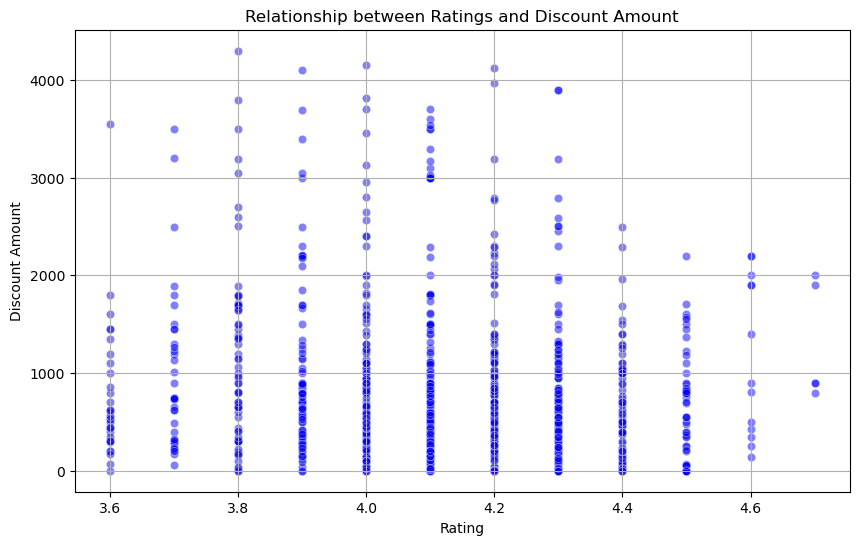

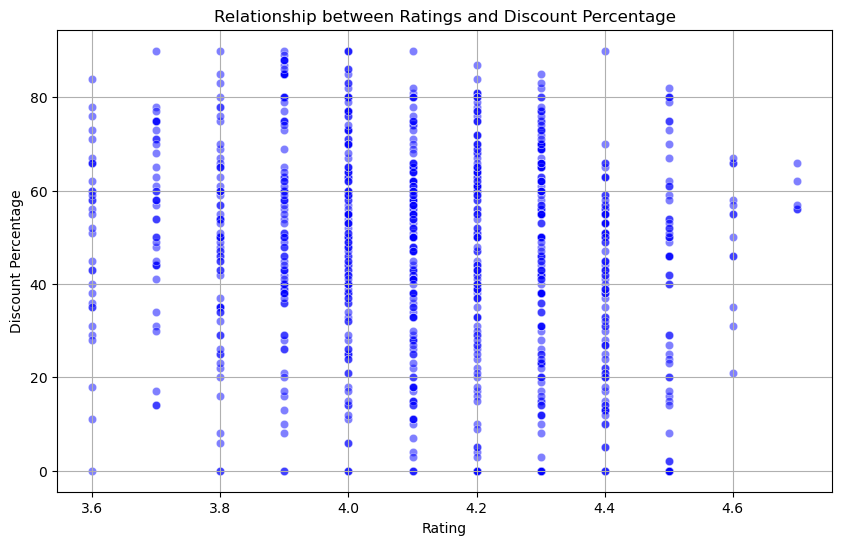

In [8]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=cleanData1_filtered, x='rating', y='discounted_amount', color='blue', alpha=0.5)
plt.title('Relationship between Ratings and Discount Amount')
plt.xlabel('Rating')
plt.ylabel('Discount Amount')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=cleanData1_filtered, x='rating', y='discount_percentage', color='blue', alpha=0.5)
plt.title('Relationship between Ratings and Discount Percentage')
plt.xlabel('Rating')
plt.ylabel('Discount Percentage')
plt.grid(True)
plt.show()

In [9]:
cleanData1_filtered = cleanData1_filtered.drop(columns=['discounted_price','actual_price', 'rating_count'])
cleanData1 = cleanData1.drop(columns=['discounted_price','actual_price','rating_count'])

In [10]:
cleanData1.skew()

rating                -1.242895
discount_percentage   -0.290532
discounted_amount      5.022515
rating_weighted        5.826726
dtype: float64

In [11]:

cleanData1_filtered.skew()

rating                -0.183505
discount_percentage   -0.433738
discounted_amount      1.774535
rating_weighted        1.521164
dtype: float64

In [12]:
cleanData1_filtered.corr()

,rating,discount_percentage,discounted_amount,rating_weighted
rating,1.000000,-0.150185,-0.107689,0.204002
discount_percentage,-0.150185,1.000000,0.382910,-0.092628
discounted_amount,-0.107689,0.382910,1.000000,0.034243
rating_weighted,0.204002,-0.092628,0.034243,1.000000


In [13]:
cleanData1.corr()

,rating,discount_percentage,discounted_amount,rating_weighted
rating,1.000000,-0.155375,0.105805,0.115217
discount_percentage,-0.155375,1.000000,0.086675,0.010701
discounted_amount,0.105805,0.086675,1.000000,-0.044149
rating_weighted,0.115217,0.010701,-0.044149,1.000000


In [ ]:
#low .corr() score means low linear correlation.